
# Introducción a distancias y matrices de distancia para **clustering**


> Este notebook es autocontenido y didáctico. Incluye definiciones, intuiciones, código detallado y visualizaciones para entender **distancias**, **métricas**, **matrices de distancia** y sus implicaciones para **clustering**.



## Objetivos de aprendizaje
Al finalizar este notebook, deberías ser capaz de:
1. Explicar el **concepto de distancia** y distinguirlo de una métrica.
2. Reconocer y verificar las **propiedades de una métrica**: no negatividad, identidad, simetría y desigualdad triangular.
3. Construir y leer **matrices de distancia** (cuadradas y por pares).
4. Calcular y usar **métricas clásicas**: Minkowski (incluye Euclídea, Manhattan, Chebyshev), Euclídea estandarizada, Mahalanobis, coseno y correlación.
5. Comprender el efecto de la **escalación y ponderación** de variables en la distancia.
6. Calcular **distancias para datos binarios**: Hamming, Simple Matching (Sokal–Michener), Jaccard, Dice/Sørensen, Russell–Rao y Yule.
7. Evaluar (de manera empírica) si una función de disimilitud cumple las propiedades de **métrica** (en particular, la **desigualdad triangular**).
8. Visualizar matrices de distancia y comprender su conexión con el **clustering** (p.ej., estructura de bloques).


In [1]:
# === Setup general ===
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Warning control
import warnings
warnings.filterwarnings('ignore')

In [2]:
#
np.random.seed(42)  # reproducibilidad


## Concepto de distancia y propiedades de una **métrica**

Sea un espacio de objetos $\mathbf{X}$. Una **distancia** es una regla que asigna a cada par de elementos $x, y \in \mathbf{X}$ un número real $d(x,y)\ge 0$ que mide su **disimilitud**.

Una **métrica** es una distancia que satisface, para todo $x, y, z \in \mathbf{X}$:

1. **No negatividad:** $d(x,y)\ge 0$.
2. **Identidad de los indiscernibles:** $d(x,y)=0$ si y solo si $x=y$.
3. **Simetría:** $d(x,y)=d(y,x)$.
4. **Desigualdad triangular:** $d(x,z) \leq d(x,y)+d(y,z)$.

**Importante:** Algunas funciones de disimilitud no cumplen todas estas propiedades (p.ej. la *distancia coseno* puede violar la triangularidad). En clustering, usar funciones no métricas puede afectar métodos que asumen métrica.


https://editor.p5js.org/benjov/full/O_pUWhsEH


## Distancias de Minkowski ( $\ell_p$ )

Para vectores $x, y \in \mathbb{R}^d$ y $p\ge 1$:

$$ d_p(x,y)=\left(\sum_{i=1}^d |x_i-y_i|^p\right)^{1/p} $$

Casos especiales:

- **Manhattan** ($p=1$)
- **Euclídea** ($p=2$)
- **Chebyshev** ($p\to\infty$): $\max_i |x_i-y_i|$


In [3]:
# === Distancias Minkowski ===
def minkowski_distance(x, y, p = 2.0):
    """
    Distancia de Minkowski entre vectores 1D x , y (numpy arrays) para p>=1.
    Para p=np.inf devuelve Chebyshev.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if x.shape != y.shape:
        raise ValueError("x e y deben tener la misma forma.")
    if p == np.inf:
        return np.max(np.abs(x - y))
    if p < 1:
        raise ValueError("Se requiere p >= 1 para ser una métrica (convención).")
    return np.power(np.sum(np.abs(x - y) ** p), 1.0 / p)


In [4]:
# Parametricemos algunos casos:
def manhattan_distance(x, y):
    return minkowski_distance(x, y, p = 1.0)

def euclidean_distance(x, y):
    return minkowski_distance(x, y, p = 2.0)

def chebyshev_distance(x, y):
    return minkowski_distance(x, y, p = np.inf)

In [5]:
# Prueba rápida
x = np.array([1, 2, 3])
y = np.array([4, 0, 6])

x, y

(array([1, 2, 3]), array([4, 0, 6]))

In [6]:
#
print("Manhattan:", manhattan_distance(x,y))

Manhattan: 8.0


In [7]:
#
print("Euclídea:", euclidean_distance(x,y))

Euclídea: 4.69041575982343


In [8]:
#
print("Chebyshev:", chebyshev_distance(x,y))

Chebyshev: 3.0


## Estandarización y ponderación

La escala de las variables afecta fuertemente la distancia Euclídea. Para mitigar esto:

- **Estandarización (z-score):** $z_i = \frac{(x_i-\mu_i)}{\sigma_i}$.

- **Euclídea estandarizada:** $d(x,y) = \sqrt{\sum_i \frac{(x_i-y_i)^2}{s_i^2}}$

donde $s_i^2$ es la varianza de la $i$-ésima variable en la muestra.

- **Ponderación:** $d_w(x,y) = \sqrt{\sum_i w_i (x_i-y_i)^2}$

con pesos $w_i>0$.


In [9]:
# Estandariza columnas de X
def zscore(X, ddof=1):
    """Estandariza columnas de X (muestras en filas).
    Devuelve Z y medias/sigmas.
    """
    X = np.asarray(X, dtype=float)
    mu = X.mean(axis=0)
    sigma = X.std(axis=0, ddof=ddof)
    sigma_safe = np.where(sigma==0, 1.0, sigma)
    Z = (X - mu) / sigma_safe
    return Z, mu, sigma_safe


In [10]:
# Distancia euclídea estandarizada
def standardized_euclidean_distance(x, y, variances):
    """Distancia euclídea estandarizada con varianzas por dimensión.
    variances: array 1D con varianzas > 0.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    variances = np.asarray(variances, dtype=float)
    if np.any(variances <= 0):
        raise ValueError("Las varianzas deben ser positivas.")
    diff = x - y
    return np.sqrt(np.sum((diff * diff) / variances))


In [11]:
# Weighted Euclidean Distance
def weighted_euclidean_distance(x, y, weights):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    w = np.asarray(weights, dtype=float)
    if np.any(w <= 0):
        raise ValueError("Los pesos deben ser positivos.")
    diff = x - y
    return np.sqrt(np.sum(w * diff * diff))


In [12]:
# Ejemplo: efecto de escala
X_demo = np.array([[1,  200],
                   [2,  210],
                   [3,  260],
                   [4,  230]], dtype=float)  # columna 2 domina si no se estandariza

Z_demo, mu_demo, sigma_demo = zscore(X_demo)
var_demo = sigma_demo**2

#
Z_demo#, mu_demo, sigma_demo, var_demo

array([[-1.161895  , -0.94491118],
       [-0.38729833, -0.56694671],
       [ 0.38729833,  1.32287566],
       [ 1.161895  ,  0.18898224]])

In [13]:
#
print("Distancia euclídea entre fila 0 y 3 (sin escalar):",
      euclidean_distance(X_demo[0], X_demo[3]))
print("Distancia euclídea estandarizada (mismas filas):",
      standardized_euclidean_distance(X_demo[0], X_demo[3], var_demo))

Distancia euclídea entre fila 0 y 3 (sin escalar): 30.14962686336267
Distancia euclídea estandarizada (mismas filas): 2.585674822114004



## Distancia de Mahalanobis

$$ d_M(x,y)=\sqrt{(x-y)^{\top} \mathbf{S}^{-1} (x-y)} $$

donde $\mathbf{S}$ es la **matriz de covarianzas** de los datos. Tiene en cuenta escalas y correlaciones. Es una métrica si $\mathbf{S}$ es **definida positiva**.


In [14]:
# Mahalanobis Distance
def mahalanobis_distance(x, y, S_inv):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    diff = x - y
    return float(np.sqrt(diff.T @ S_inv @ diff))


In [15]:
# Demostración con datos anisotrópicos
rng = np.random.default_rng(7) #for creating a new, isolated random number generator (RNG) instance


In [16]:
# Generamos un cluster alargado y correlacionado
n = 150
mean = np.array([0.0, 0.0])
C = np.array([[3.0, 2.4],
              [2.4, 4.0]])  # covarianza con correlación positiva

#
X_simul = rng.multivariate_normal(mean, C, size=n)

S = np.cov(X_simul, rowvar=False)
S_inv = np.linalg.inv(S)

S, S_inv

(array([[2.71893129, 2.1134649 ],
        [2.1134649 , 3.31843007]]),
 array([[ 0.72838887, -0.46390139],
        [-0.46390139,  0.59680007]]))

Ver: https://editor.p5js.org/benjov/full/wNCFlnKXX

In [17]:
# Comparamos dos puntos alejados a lo largo de la dirección principal
a = X_simul[0]
b = X_simul[1]

a, b

(array([-0.23923249,  0.19066095]), array([ 1.12946   , -0.05643399]))

In [18]:
#
print("Euclídea(a,b):", euclidean_distance(a,b))
print("Mahalanobis(a,b):", mahalanobis_distance(a,b, S_inv))

Euclídea(a,b): 1.3908181204043144
Mahalanobis(a,b): 1.3094743579881543


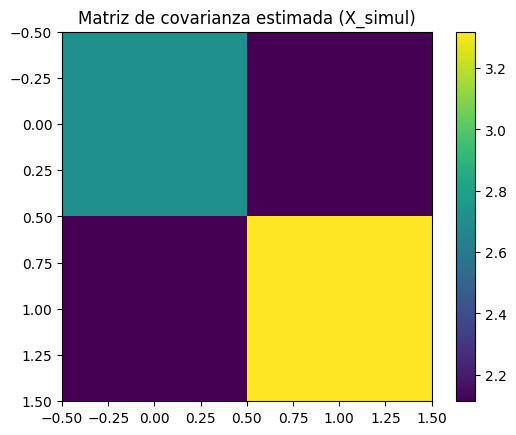

In [19]:
# Visualización de la matriz de covarianza estimada
plt.figure()
plt.title("Matriz de covarianza estimada (X_simul)")
plt.imshow(S)
plt.colorbar()
plt.show()



## Distancia coseno y distancia por correlación
- **Coseno:**
$$ d_{\cos}(x,y)=1-\frac{x\cdot y}{\lVert x\rVert\,\lVert y\rVert}$$

 Mide ángulo (dirección) más que magnitud. **No siempre es métrica** (puede violar triangularidad).

- **Correlación (Pearson):**

$$ d_{\mathrm{corr}}(x,y)=1-\rho(x,y) $$

También puede fallar la triangularidad.

> Nota: La **distancia angular** $\theta(x,y)=\arccos(\frac{x\cdot y}{\lVert x\rVert\,\lVert y\rVert})$ sí es métrica.

https://editor.p5js.org/benjov/full/xNgY8aQdA


In [20]:
# Cosine Distance
def cosine_distance(x, y, eps = 1e-12):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    nx = np.linalg.norm(x)
    ny = np.linalg.norm(y)
    if nx < eps or ny < eps:
        # Si alguno es vector nulo, definimos distancia 0 si ambos son nulos; 1 en otro caso
        return 0.0 if nx < eps and ny < eps else 1.0
    cos = float(np.dot(x, y) / (nx * ny))
    # proteger contra errores numéricos leves
    cos = max(min(cos, 1.0), -1.0)
    return 1.0 - cos


In [21]:
# Correlation Distance
def correlation_distance(x, y, eps = 1e-12):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    x_centered = x - x.mean()
    y_centered = y - y.mean()
    nx = np.linalg.norm(x_centered)
    ny = np.linalg.norm(y_centered)
    if nx < eps or ny < eps:
        # si alguno es constante, definimos distancia 1 salvo que ambos sean "constantes idénticos"
        return 1.0
    corr = float(np.dot(x_centered, y_centered) / (nx * ny))
    corr = max(min(corr, 1.0), -1.0)
    return 1.0 - corr


In [22]:
# Prueba
x = np.array([1, 0, 1, 0, 1], dtype=float)
y = np.array([2, 0, 2, 0, 2], dtype=float)
z = np.array([0, 1, 0, 1, 0], dtype=float)

In [23]:
#
print("Cos(x,y), Cos(x,z):", cosine_distance(x,y), cosine_distance(x,z))
print("Corr(x,y), Corr(x,z):", correlation_distance(x,y), correlation_distance(x,z))


Cos(x,y), Cos(x,z): 0.0 1.0
Corr(x,y), Corr(x,z): 2.220446049250313e-16 1.9999999999999998



## Visualizando matrices de distancia
Una **matriz de distancia** revela estructura de bloques cuando los datos contienen clusters. Ilustramos con datos sintéticos.


In [24]:
# Generamos 3 clusters en 2D, con escalas distintas para evidenciar efecto de estandarización
rng = np.random.default_rng(2025)

n1, n2, n3 = 60, 60, 60

C1 = np.array([[0.5, 0.0],[0.0, 2.0]])

C2 = np.array([[1.5, 0.8],[0.8, 1.5]])

C3 = np.array([[0.3, 0.0],[0.0, 0.3]])

X1 = rng.multivariate_normal([0,  0],  C1, size=n1)

X2 = rng.multivariate_normal([6, 10], C2, size=n2)

X3 = rng.multivariate_normal([12, 1], C3, size=n3)


In [25]:
#
X = np.vstack([X1, X2, X3])

labels = np.array([0]*n1 + [1]*n2 + [2]*n3)

#X, labels

In [26]:
# Matriz de distancia euclídea sin escalar
# --- Matriz de distancia euclídea sin usar funciones externas ---
# X: (n, d)
D_euc = np.sqrt(np.sum((X[:, None, :] - X[None, :, :])**2, axis=2))

# Reordenamos por etiqueta para visualizar bloques
order = np.argsort(labels)
D_sorted = D_euc[np.ix_(order, order)]


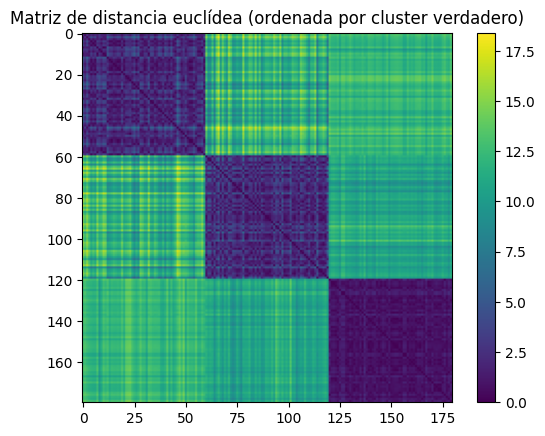

In [27]:
#
plt.figure()
plt.title("Matriz de distancia euclídea (ordenada por cluster verdadero)")
im = plt.imshow(D_sorted)
plt.colorbar(im)
plt.show()

In [28]:
# --- Estandarización (z-score) robusta a varianza cero ---
mu = X.mean(axis=0)
sigma = X.std(axis=0, ddof=1)
sigma_safe = np.where(sigma == 0, 1.0, sigma)
Z = (X - mu) / sigma_safe


In [29]:
# --- Matriz de distancia euclídea sobre los datos estandarizados ---
D_euc_std = np.sqrt(np.sum((Z[:, None, :] - Z[None, :, :])**2, axis=2))

# Reordenamos por etiqueta para visualizar bloques
order = np.argsort(labels)
D_sorted_std = D_euc_std[np.ix_(order, order)]


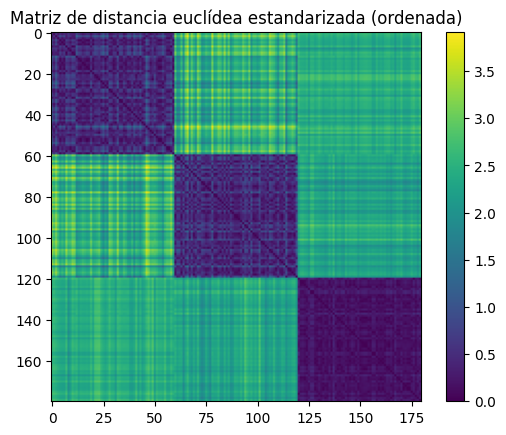

In [30]:
#
plt.figure()
plt.title("Matriz de distancia euclídea estandarizada (ordenada)")
im = plt.imshow(D_sorted_std)
plt.colorbar(im)
plt.show()

## Distancias para datos **binarios**

Sea un par de vectores binarios $u, v \in \{0,1\}^d$.

Definimos la tabla de contingencia por componente:
- $a_1$: conteo de posiciones con $u_i=1, v_i=1$
- $a_2$: conteo de posiciones con $u_i=1, v_i=0$
- $a_3$: conteo de posiciones con $u_i=0, v_i=1$
- $a_4$: conteo de posiciones con $u_i=0, v_i=0$
- $n = a+b+c+d$

**Métricas/Disimilitudes comunes:**

- **Hamming (normalizada):** $\frac{a_2 + a_3}{n}$.

- **Simple Matching (Sokal–Michener):** similitud $\frac{a_1 + a_4}{n}$ $\Rightarrow$ distancia $1-\frac{a_1 + a_4}{n}$.

- **Jaccard (asimétrica):** similitud $\frac{a_1}{a_1+a_2+a_3}$ $\Rightarrow$ distancia $1-\frac{a_1}{a_1+a_2+a_3}$. Ignora coincidencias 0–0.

- **Dice/Sørensen:** similitud $\frac{2a_1}{2a_1+a_2+a_3}$ \(\Rightarrow\) distancia $\frac{2a_1}{2a_1+a_2+a_3}$.

- **Russell–Rao:** distancia $1-\frac{a_1}{n}$.

- **Yule (Q/Y):** una disimilitud común es $\frac{2a_2 a_3}{a_1 a_4 + a_2 a_3}$ (penaliza discordancias 1–0 / 0–1).

> En datos con variables binarias **asimétricas** (p.ej., presencia/ausencia de un rasgo poco frecuente), Jaccard/Dice suelen ser preferibles porque **no** premian acuerdos 0–0.


In [31]:
# Binary Contingency
def binary_contingency(u, v):
    u = np.asarray(u, dtype=int)
    v = np.asarray(v, dtype=int)
    if u.shape != v.shape:
        raise ValueError("u y v deben tener la misma forma.")
    if not set(np.unique(u)).issubset({0,1}) or not set(np.unique(v)).issubset({0,1}):
        raise ValueError("u y v deben ser binarios (0/1).")
    a = int(np.sum((u==1) & (v==1)))
    b = int(np.sum((u==1) & (v==0)))
    c = int(np.sum((u==0) & (v==1)))
    d = int(np.sum((u==0) & (v==0)))
    n = a+b+c+d
    return a,b,c,d,n


In [32]:
# Definición de distancias:
def hamming_distance_bin(u, v):
    a,b,c,d,n = binary_contingency(u,v)
    return (b + c) / n if n>0 else 0.0

def simple_matching_distance(u, v):
    a,b,c,d,n = binary_contingency(u,v)
    return 1.0 - (a + d) / n if n>0 else 0.0

def jaccard_distance(u, v):
    a,b,c,d,n = binary_contingency(u,v)
    den = (a + b + c)
    return 0.0 if den==0 else (1.0 - a/den)

def dice_distance(u, v):
    a,b,c,d,n = binary_contingency(u,v)
    den = (2*a + b + c)
    return 0.0 if den==0 else (1.0 - (2*a)/den)

def russell_rao_distance(u, v):
    a,b,c,d,n = binary_contingency(u,v)
    return 1.0 - (a / n) if n>0 else 0.0

def yule_distance(u, v):
    # Disimilitud tipo Yule Y = 2bc/(ad+bc)
    a,b,c,d,n = binary_contingency(u,v)
    den = (a*d + b*c)
    if den == 0:
        # Si no hay ni concordancias 1-1 con 0-0 ni discordancias, definimos 0 si iguales, 1 si distintos
        return 0.0 if (b+c)==0 else 1.0
    return (2.0 * b * c) / den


In [33]:
# Matriz de distancia binaria genérica
def pairwise_binary_distance_matrix(B, metric='jaccard'):
    B = np.asarray(B, dtype=int)
    n = B.shape[0]
    D = np.zeros((n,n), dtype=float)
    for i in range(n):
        for j in range(i+1, n):
            if metric == 'hamming':
                d = hamming_distance_bin(B[i], B[j])
            elif metric == 'simple_matching':
                d = simple_matching_distance(B[i], B[j])
            elif metric == 'jaccard':
                d = jaccard_distance(B[i], B[j])
            elif metric == 'dice':
                d = dice_distance(B[i], B[j])
            elif metric == 'russell_rao':
                d = russell_rao_distance(B[i], B[j])
            elif metric == 'yule':
                d = yule_distance(B[i], B[j])
            else:
                raise ValueError("Métrica binaria no soportada.")
            D[i,j] = D[j,i] = d
    return D


In [34]:
# Datos binarios sintéticos: "adopción" de 8 rasgos/productos (rasgos raros en general)
rng = np.random.default_rng(99)
n_obs, d_dim = 60, 8
# Grupo A con alta propensión al rasgo 1 y 2
A = (rng.uniform(size=(30,d_dim)) < np.array([0.6,0.5, 0.2,0.1,0.1,0.1,0.1,0.1])).astype(int)
# Grupo B con alta propensión al rasgo 3 y 4
B = (rng.uniform(size=(30,d_dim)) < np.array([0.1,0.1, 0.6,0.5,0.1,0.1,0.1,0.1])).astype(int)
Bin = np.vstack([A,B])
bin_labels = np.array([0]*30 + [1]*30)


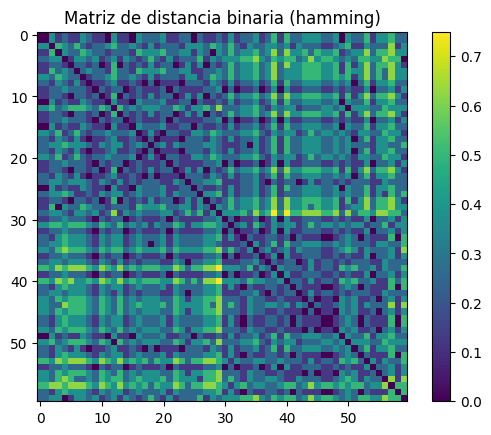

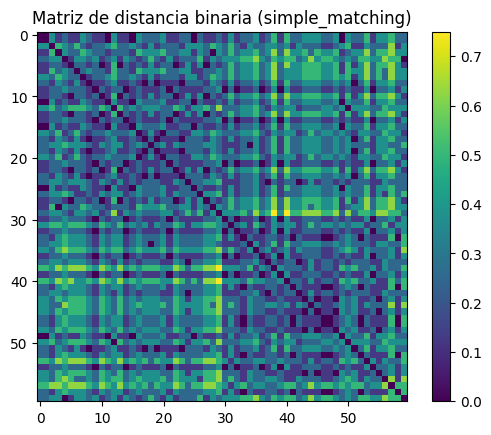

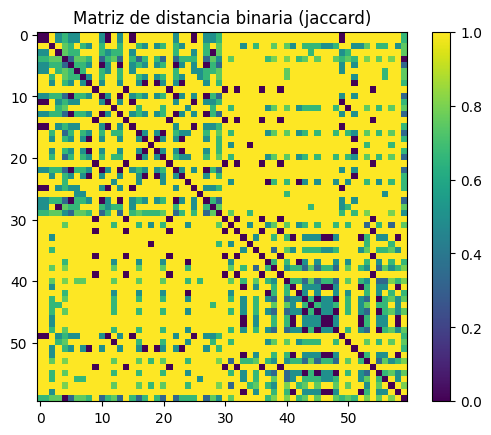

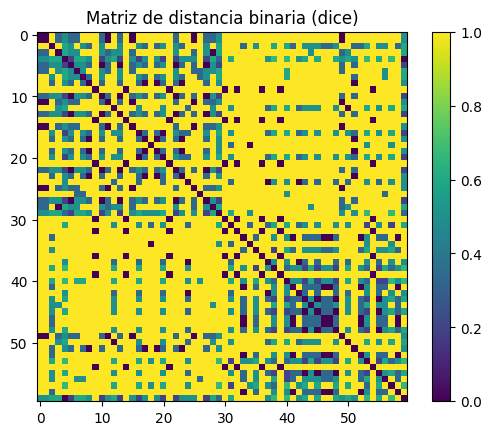

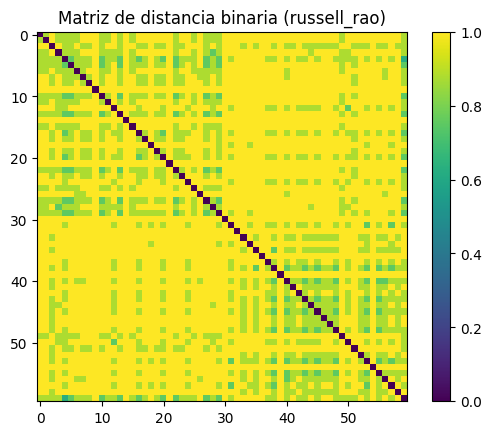

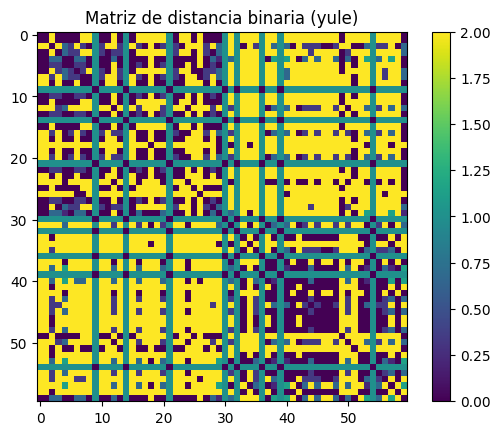

In [35]:
#
for name in ["hamming", "simple_matching", "jaccard", "dice", "russell_rao", "yule"]:
    D_bin = pairwise_binary_distance_matrix(Bin, metric=name)
    order_bin = np.argsort(bin_labels)
    plt.figure()
    plt.title(f"Matriz de distancia binaria ({name})")
    plt.imshow(D_bin[np.ix_(order_bin, order_bin)])
    plt.colorbar()
    plt.show()
